# Handwritten Recognition

## Importations

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data

The data can be decomposed into different parts : the training, validation and test sets.

For each set, we have a global .csv file in which we have the true label of each picture. Here, each picture is given by its name. To obtain the real image linked to this name, we have to use the train, validation or test directories, in which each image is stored.

### Importation of the data

In [3]:
train = pd.read_csv('/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/Inputs/written_name_train_v2.csv')
valid = pd.read_csv('/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/Inputs/written_name_validation_v2.csv')
test = pd.read_csv('/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/Inputs/written_name_test_v2.csv')

In [4]:
print("TRAIN",train.head(),"\n")
print("VALID",valid.head(),"\n")
print("TEST",test.head(),"\n")

TRAIN           FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE 

VALID               FILENAME    IDENTITY
0  VALIDATION_0001.jpg       BILEL
1  VALIDATION_0002.jpg  LAUMIONIER
2  VALIDATION_0003.jpg         LEA
3  VALIDATION_0004.jpg   JEAN-ROCH
4  VALIDATION_0005.jpg        RUPP 

TEST         FILENAME  IDENTITY
0  TEST_0001.jpg     KEVIN
1  TEST_0002.jpg  CLOTAIRE
2  TEST_0003.jpg      LENA
3  TEST_0004.jpg     JULES
4  TEST_0005.jpg   CHERPIN 



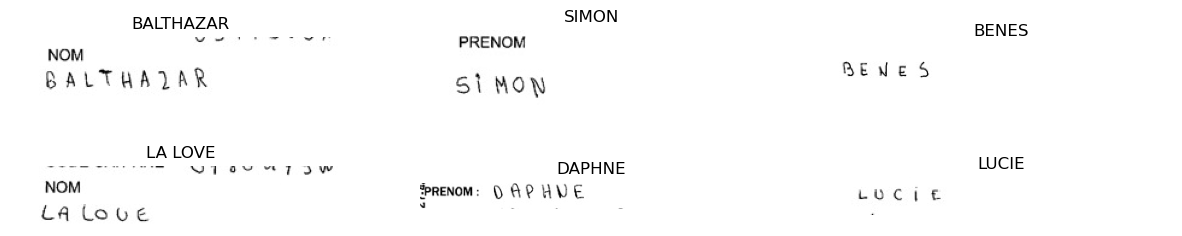

In [5]:
# Let's visualize the images of the dataset
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    # We select the pah of the image
    img_dir = '/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/Inputs/train/'+train.loc[i, 'FILENAME']
    # We read the image
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    # We show it
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

### Cleaning the data

In [6]:
print("In train set, there are : ", train['IDENTITY'].isnull().sum(), "NaN values.")
print("In validation set, there are : ", valid['IDENTITY'].isnull().sum(), "NaN values.")
print("In test set, there are : ", test['IDENTITY'].isnull().sum(), "NaN values.")

# We delete those elements
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

In train set, there are :  565 NaN values.
In validation set, there are :  78 NaN values.
In test set, there are :  70 NaN values.


In the 3 datasets, there is another type of problem in the data. In fact, some elements are considered as "non-readable". Hence, we cannot use those images in our training since the label is unknown. Then, we are going to delete those images also.

We can print some examples fo this type of images.

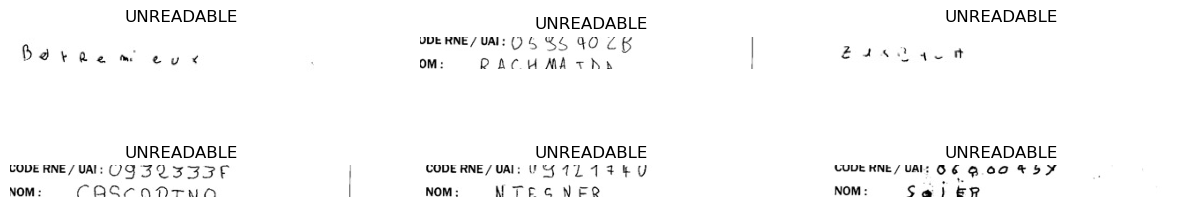

In [7]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/Inputs/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [8]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
test = test[test['IDENTITY'] != 'UNREADABLE']

In [9]:
# Last changes in the data
## Put all the labels into lower case letters
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()

## Reset the indexes of the
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)
test.reset_index(inplace = True, drop=True)

### Preprocessing the dataset

Some images are not in the same shape. Then, we have to uniformized the shape of each image of the datasets. Here, we will consider images of 256x64 pixels.

Then, if the dimensions of an image is bigger than those numbers, the width/height are cropped, and if the shape is smaller, we apply a padding with white pixels.

Finally the image is rotated clockwise to bring the image shape to (x, y), and is then normalized to range [0, 1].

In [10]:
def preprocess(img):
    # We get the sape of the current image
    (h, w) = img.shape
    # We initialize our new image
    final_img = np.ones([64, 256])*255

    # If the current image is too big (bigger height/width), we crop it
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]

    # We put the cropped image into our new image
    final_img[:h, :w] = img
    # We apply the rotation
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [11]:
def create_dataset(train_size,valid_size):
  train_images = []
  valid_images = []

  for i in range(train_size):
      img_train = '/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/Inputs/train/'+train.loc[i, 'FILENAME']
      image_train = cv2.imread(img_train, cv2.IMREAD_GRAYSCALE)
      image_train = preprocess(image_train)
      image_train = image_train/255.
      train_images.append(image_train)

      if i < valid_size:
        img_valid = '/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/Inputs/validation/'+valid.loc[i, 'FILENAME']
        image_valid = cv2.imread(img_valid, cv2.IMREAD_GRAYSCALE)
        image_valid = preprocess(image_valid)
        image_valid = image_valid/255.
        valid_images.append(image_valid)



  train_images = np.array(train_images).reshape(-1, 256, 64, 1)
  valid_images = np.array(valid_images).reshape(-1, 256, 64, 1)

  return train_images, valid_images

In [12]:
train_size = 30080
valid_size= 3200

train_images, valid_images = create_dataset(train_size, valid_size)
train_images = train_images.astype(np.float32)
valid_images = valid_images.astype(np.float32)

The labels have to be converted to numbers which represent each character in the training set. We will here create an alphabet, which consist of A-Z letters and three special characters : <->, <'> and < >.

In [13]:
labels = train['IDENTITY']
max_word = 0
for word in labels:
  l = len(word)
  if l > max_word:
    max_word = l

print(l)

7


The maximum word's length over our whole dataset is 7.

In [14]:
alphabets = u" ABCDEFGHIJKLMNOPQRSTUVWXYZ-'"
max_str_len = 24 # max length of input labels

num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

def label_to_num(label):
    # We initialize the output vector
    label_num = []
    # For each character of the label, we add the corresponding number
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num,alphabet=alphabets):
    # We initialize the output string
    ret = ""
    # For each number, we add the element of the alphabet at that position
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

Now, we can test if our last functions work properly.


In [15]:
name = 'DAVID'
print(name, " : ", label_to_num(name))
print(label_to_num(name), " : ", num_to_label(label_to_num(name)) )

DAVID  :  [ 4  1 22  9  4]
[ 4  1 22  9  4]  :  DAVID


Now, let's create certain lists, that will be useful for the training:
- *train_y* : contains the true labels converted to numbers and padded with -1.
- *max_str_len* : length of each label
- *train_label_len* : contains the length of each true label (without padding)
- *train_input_len* : contains the length of each predicted label
- *train_output* : a dummy output for ctc loss.

In [16]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

train_y = train_y.astype(int)
train_label_len = train_label_len.astype(int)
train_input_len = train_input_len.astype(int)

train_label_len = torch.from_numpy(train_label_len)
train_input_len = torch.from_numpy(train_input_len)

In [17]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

valid_y = valid_y.astype(int)
valid_label_len = valid_label_len.astype(int)
valid_input_len = valid_input_len.astype(int)

valid_images,valid_y,valid_label_len,valid_input_len


valid_label_len = torch.from_numpy(valid_label_len)
valid_input_len = torch.from_numpy(valid_input_len)

In [18]:
class HandWrittenDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    image = self.images[idx]
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

In [19]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = HandWrittenDataset(train_images, train_y, transform=transform)
valid_dataset = HandWrittenDataset(valid_images, valid_y, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

## First model

In [20]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [21]:
class CRNN(nn.Module):
    def __init__(self, rnn_input_dim, rnn_hidden_dim, n_rnn_layers, output_dim, drop_prob=0.):
        super(CRNN, self).__init__()
        self.rnn_input_dim = rnn_input_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.n_rnn_layers = n_rnn_layers
        self.output_dim = output_dim

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
        self.norm1 = nn.BatchNorm2d(32)
        #nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in',nonlinearity='relu')
        #self.dropout1 = nn.Dropout2d(p=drop_prob)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.norm2 = nn.BatchNorm2d(64)
        #nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in',nonlinearity='relu')
        self.dropout2 = nn.Dropout2d(p=drop_prob)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.norm3 = nn.BatchNorm2d(128)
        #nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in',nonlinearity='relu')
        self.dropout3 = nn.Dropout2d(p=drop_prob)

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(1,2))

        self.rnn = nn.LSTM(rnn_input_dim, rnn_hidden_dim, n_rnn_layers, batch_first=True, bidirectional=True, dropout=drop_prob)

        self.fc1 = nn.Linear(1024, rnn_input_dim)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in',nonlinearity='relu')
        #nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(2*rnn_hidden_dim, output_dim)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in',nonlinearity='relu')
        #nn.init.xavier_uniform_(self.fc2.weight)

                                      # Batch, Channel, Width, Height
    def forward(self, x, h, c=None):  # Size : b,  1, 256, 64
        x = self.conv1(x)             # Size : b, 32, 256, 64
        x = self.norm1(x)             # Size : b, 32, 256, 64
        x = F.relu(x)                 # Size : b, 32, 256, 64
        x = self.maxpool(x)           # Size : b, 32, 128, 32

        x = self.conv2(x)             # Size : b, 64, 128, 32
        x = self.norm2(x)             # Size : b, 64, 128, 32
        x = F.relu(x)                 # Size : b, 64, 128, 32
        x = self.maxpool(x)           # Size : b, 64,  64, 16
        x = self.dropout2(x)

        x = self.conv3(x)             # Size : b, 128, 64, 16
        x = self.norm3(x)             # Size : b, 128, 64, 16
        x = F.relu(x)                 # Size : b, 128, 64, 16
        x = self.maxpool2(x)          # Size : b, 128, 64,  8
        x = self.dropout3(x)

        x = x.permute(0,2,3,1)        # Size : b, 64, 8, 128
        x = x.reshape((x.shape[0], x.shape[1], 1024)) # Size : b, 64, 1024

        x = self.fc1(x)               # Size : b,  64, 64
        x = F.relu(x)                 # Size : b,  64, 64

        x, (h, c) = self.rnn(x, (h, c))    # Size : b, 64, 1024

        x = self.fc2(x)               # Size : b, 64, 30
        x = F.log_softmax(x, dim=2)
        return x, h, c

    def init_hidden(self, batch_size):
        #Initialize the hidden state of the RNN to zeros
        weight = next(self.parameters()).data
        return weight.new(2*self.n_rnn_layers, batch_size, self.rnn_hidden_dim).zero_().cuda(), weight.new(2*self.n_rnn_layers, batch_size, self.rnn_hidden_dim).zero_().cuda()

In [22]:
def gradient_clipping(model, min, max):
  for name, param in model.named_parameters():
    if param.grad is not None:
      param.grad.data = torch.clamp(param.grad.data, min=min, max=max)
      param.grad.data[param.grad.data.abs() < min] = min

In [23]:
def decode(pred,batch_size,str_len):
  decoded_batch = np.ones((batch_size,str_len),dtype=int)*(-1)
  blank=0
  pred = pred.cpu().numpy()

  for b in range(batch_size):
    previous_letter = blank
    index=0
    for k in range(64):
      letter = pred[b,k]
      if letter != previous_letter and letter != blank:
        decoded_batch[b,index] = letter.item()
        previous_letter = letter
        index+=1

  return decoded_batch

In [24]:
def train_model(dataloader, model, batch_size, criterion, optimizer, num_epochs, valid_loader):
    train_losses = []
    valid_losses = []
    words_acc_val = []
    letters_acc_val = []

    for epoch in range(num_epochs):
        model.train()

        for batch, (x, y) in enumerate(dataloader):
            h_state, c_state = model.init_hidden(batch_size)

            h_state = h_state.to(device)

            if c_state is not None:
                c_state = c_state.to(device)

            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            y_pred, h_state, c_state = model(x, h_state, c_state)

            #input_lengths = torch.full(size=(batch_size,), fill_value=64, dtype=torch.long)
            #target_lengths = torch.full(size=(batch_size,), fill_value=1, dtype=torch.long)
            target_lengths = train_label_len[(batch*batch_size):((batch+1)*batch_size)]
            input_lengths = train_input_len[(batch*batch_size):((batch+1)*batch_size)]

            loss = criterion(y_pred.transpose(1,0), y, input_lengths, target_lengths) #.transpose(1, 2)
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            #gradient_clipping(model, 0.0001, 1)

            #for name, param in model.named_parameters():
              #if param.grad is not None:
                #print(name, torch.mean(param.grad).item(), loss.item())

            optimizer.step()

            if batch%30 == 0:
              print({ 'batch': batch, 'epoch': epoch, 'training loss': loss.item()})

        val_loss, accuracy_words, accuracy_letters = validate(criterion, model, valid_loader, batch_size)

        train_losses.append(loss.item())
        valid_losses.append(val_loss)
        words_acc_val.append(accuracy_words)
        letters_acc_val.append(accuracy_letters)

        print({ 'epoch': epoch, 'training loss': loss.item(), 'validation loss':val_loss, "Words accuracy":accuracy_words, "Letters accuracy":accuracy_letters})

    return train_losses, valid_losses, words_acc_val, letters_acc_val


In [25]:
rnn_input_dim = 64
rnn_hidden_dim = 512
output_dim = num_of_characters
n_rnn_layers = 2
drop_prob = 0.3

torch.backends.cudnn.benchmark = True
torch.manual_seed(0) # seed for reproductibility
criterion = torch.nn.CTCLoss()

model = CRNN(rnn_input_dim, rnn_hidden_dim, n_rnn_layers, output_dim, drop_prob).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) #

print(f"Number of parameters {get_n_params(model)}:")
model.to(device)

Number of parameters 8856606:


CRNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.3, inplace=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (rnn): LSTM(64, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=1024, out_features=30, bias=True)
)

In [26]:
@torch.no_grad()  # prevent this function from computing gradients
def validate(criterion, model, loader, batch_size):

    val_loss = 0
    correct_words = 0
    correct_letters = 0
    n_letters = 0

    model.eval()

    for batch, (data, target) in enumerate(loader):
        h_state, c_state = model.init_hidden(batch_size)

        h_state = h_state.to(device)

        if c_state is not None:
          c_state = c_state.to(device)


        data, target = data.to(device), target.to(device)

        output, h_state, c_state = model(data, h_state, c_state)

        #input_lengths = torch.full(size=(batch_size,), fill_value=64, dtype=torch.long)
        #target_lengths = torch.full(size=(batch_size,), fill_value=1, dtype=torch.long)

        target_lengths = valid_label_len[(batch*batch_size):((batch+1)*batch_size)]
        input_lengths = valid_input_len[(batch*batch_size):((batch+1)*batch_size)]

        loss = criterion(output.transpose(0, 1), target, input_lengths, target_lengths)

        val_loss += loss.item()

        _, pred = torch.max(output.data,dim=2)

        target = target.cpu().numpy()

        pred = decode(pred,batch_size,24)

        correct_words += np.sum(np.sum((abs(target-pred)),axis=1)==0)
        correct_letters += np.sum(abs(target-pred)==0, where=(target!=-1))

        n_letters += np.sum(target!=-1)

    val_loss /= 25
    accuracy_words = correct_words / len(loader.dataset)
    accuracy_letters = correct_letters / n_letters
    #print('\nTest set: Average loss: {:.4f}, Word accuracy: {}/{} ({:.0f}%), Letter accuracy: {}/{} ({:.0f}%)\n'.format(
        #val_loss, correct_words, len(loader.dataset), accuracy_words, correct_letters, n_letters, accuracy_letters))


    return val_loss, accuracy_words, accuracy_letters

In [27]:
batch_size = 128
num_epochs = 10

train_loss, valid_loss, words_acc_val, letters_acc_val = train_model(train_loader, model, batch_size, criterion, optimizer, num_epochs, valid_loader)

{'batch': 0, 'epoch': 0, 'training loss': 29.654491424560547}
{'batch': 30, 'epoch': 0, 'training loss': 3.182358741760254}
{'batch': 60, 'epoch': 0, 'training loss': 3.0814740657806396}
{'batch': 90, 'epoch': 0, 'training loss': 3.049287796020508}
{'batch': 120, 'epoch': 0, 'training loss': 2.92344331741333}
{'batch': 150, 'epoch': 0, 'training loss': 2.910961866378784}
{'batch': 180, 'epoch': 0, 'training loss': 2.7777323722839355}
{'batch': 210, 'epoch': 0, 'training loss': 2.5350747108459473}
{'epoch': 0, 'training loss': 2.421987295150757, 'validation loss': 2.376825065612793, 'Words accuracy': 0.005, 'Letters accuracy': 0.1333206361298924}
{'batch': 0, 'epoch': 1, 'training loss': 2.4077212810516357}
{'batch': 30, 'epoch': 1, 'training loss': 2.1935133934020996}
{'batch': 60, 'epoch': 1, 'training loss': 1.748805046081543}
{'batch': 90, 'epoch': 1, 'training loss': 1.5703802108764648}
{'batch': 120, 'epoch': 1, 'training loss': 1.3456848859786987}
{'batch': 150, 'epoch': 1, 'trai

Text(0.5, 1.0, 'Letters accuracy')

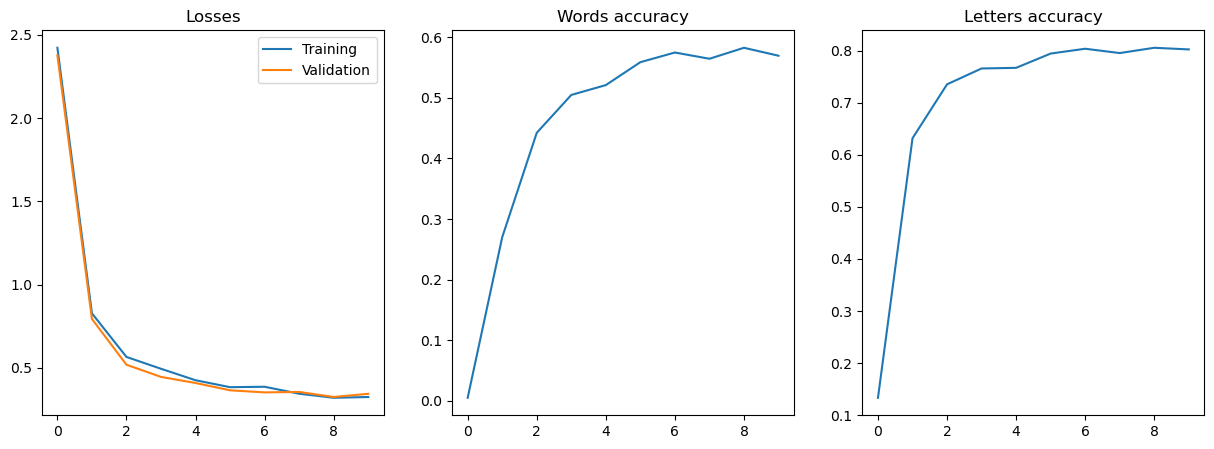

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.title("Losses")
plt.legend()

plt.subplot(1,3,2)
plt.plot(words_acc_val)
plt.title("Words accuracy")

plt.subplot(1,3,3)
plt.plot(letters_acc_val)
plt.title("Letters accuracy")

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

CRNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.3, inplace=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (rnn): LSTM(64, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=1024, out_features=30, bias=True)
)

In [30]:
# Check if the model is on the GPU
if next(model.parameters()).is_cuda:
    print("The model is on GPU.")
else:
    print("The model is not on GPU.")

The model is on GPU.


In [31]:
def preprocess(img):
    # We get the sape of the current image
    (h, w) = img.shape
    # We initialize our new image
    final_img = np.ones([64, 256])*255

    # If the current image is too big (bigger height/width), we crop it
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]

    # We put the cropped image into our new image
    final_img[:h, :w] = img
    # We apply the rotation
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [83]:
image_paths = ['/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/IMAGES_EXTRA/name_trial_andreu.jpg','/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/IMAGES_EXTRA/name_trial_pere.jpg','/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/IMAGES_EXTRA/name_trial_mathias.jpg']

In [84]:
from PIL import Image

In [85]:
def init_hidden(batch_size, n_rnn_layers, rnn_hidden_dim):
    return (torch.zeros(2*n_rnn_layers, batch_size, rnn_hidden_dim).to(device),
            torch.zeros(2*n_rnn_layers, batch_size, rnn_hidden_dim).to(device))

In [86]:
def test_own_image(model,dir,max_str_len,device,save_path):
    """
    Apply the model on 3 images made by ourselves.
    
    Parameters 
    ----------
    model : CRNN - Model to apply
    dir : String - Path of the images
    names : List - Names of the files
    alphabet : String - Alphabet used for decoding
    max_str_len : Int - Maximum label length
    device : torch.device - GPU or CPU
    """
    k=0
    for image_path in dir:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
        image = preprocess(binary_image)/255.
        image = image.astype(np.float32)
        
        h, c = model.init_hidden(1)
        h = h.to(device)
        if c is not None:
            c = c.to(device)
            
        input = torch.tensor(image)
        input = input.reshape((1, 1, input.shape[0], input.shape[1]))
        input = input.to(device)
            
        pred, h, c = model(input,h,c)

        _, pred = torch.max(pred,dim=2)
        pred = decode(pred,1,max_str_len)
        pred = num_to_label(pred[0])
        
        plt.subplot(1, 3, k+1)
        plt.imshow(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE), cmap = 'gray')
        plt.title(pred, fontsize=12)
        plt.axis('off')
        k+=1
    
    plt.subplots_adjust(wspace=0.2, hspace=-0.8)
    plt.savefig(save_path)
    plt.clf()

In [87]:
test_own_image(model=model,dir=image_paths,max_str_len=max_str_len,device=device, save_path='/home/xnmaster/.vscode/deep-learning-project-2024-ai_nndl_group_14/IMAGES_EXTRA/FINAL')

<Figure size 640x480 with 0 Axes>